# GPcounts applied to scRNA-Seq time series data

Nuha BinTayyash, 2020

GPcounts is a Gaussian process regression package for counts data with negative binomial and zero-inflated negative binomial likelihoods as described in the paper "Non-parametric modelling of temporal and spatial counts data from RNA-seq experiments".


This notebook shows how to fit GPcounts with zero-inflated negative binomial, negative binomial and Gaussian likelihoods using full inference on ScRNA-seq gene expression data in Islet $\alpha$ cell from [GSE8737 single cell RNA-seq ](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE87375) dataset to find differentially expressed genes using infer trajectory and compare it with GPcounts with sparse inferece to obtain to obtain computational efficiency.

In [1]:
import pandas as pd
import numpy as np
import random
import gpflow 
from IPython.display import display

Load $\alpha$ gene expression data and pseudotime information

In [2]:
Y = pd.read_csv('../data/normalized_alpha_counts.csv',index_col=[0])
X = pd.read_csv('../data/alpha_time_points.csv',index_col=[0])
X.shape

(328, 1)

In [3]:
from GPcounts.RNA_seq_GP import rna_seq_gp
from helper import plot 

In [4]:
Y = Y.rename( index={'ENSMUSG00000015879': 'Fam184b','ENSMUSG00000059173':'Pde1a'})
genes_name = ['Fam184b','Pde1a']
Y.loc[genes_name]

,aE17.5_2_09,aE17.5_2_16,aE17.5_1_11,aE17.5_3_07,aE17.5_4_06,aE17.5_3_04,aE17.5_2_11,aE17.5_1_25,aE17.5_4_01,aE17.5_4_03,...,aP18_3_12,aP60_1_11,aP60_3_05,aP15_1_15,aP60_1_13,aP60_3_08,aP60_5_16,aP18_1_17,aP60_1_10,aP60_5_05
Fam184b,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,47.446494,0.0,0.0,0.0,0.0
Pde1a,53.19138,33.888555,0.0,63.941424,60.599705,40.608317,15.368216,23.786486,3.812432,44.32606,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


Probabilty of zeros in Fam184b and Pde1a genes

In [5]:
Y.loc[genes_name][Y.loc[genes_name] == 0].count(axis=1)/len(Y.columns)

Fam184b    0.859756
Pde1a      0.628049
dtype: float64

## 1. Fit GPcounts with negative binomial likelihood assuming full inference on Fam184b and Pde1a genes

In [6]:
gp_counts = rna_seq_gp(X,Y.loc[genes_name],safe_mode = True) 
likelihood =  'Negative_binomial'

In [7]:
from helper import plot_GP 

100%|█████████████████████████████████████████████| 2/2 [00:09<00:00,  4.87s/it]

The results for Negative_binomial likelihood:


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
Fam184b,-386.501825,-387.005190,0.503365
Pde1a,-818.595687,-829.576454,10.980767


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]

Fam184b


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.82174
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.141930807076911
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,32.99898
VGP.num_data,Parameter,Identity,,False,(),int32,328
VGP.q_mu,Parameter,Identity,,True,"(328, 1)",float64,[[-2.42603142e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 328, 328)",float64,"[[[8.28710183e-01, 0.00000000e+00, 0.00000000e+00..."


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,3.75844
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,35.377
VGP.num_data,Parameter,Identity,,False,(),int32,328
VGP.q_mu,Parameter,Identity,,True,"(328, 1)",float64,[[9.86708660e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 328, 328)",float64,"[[[-1.63115730e-01, 0.00000000e+00, 0.00000000e+00..."


Pde1a


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,8.17457
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.7669458395356524
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,9.48343
VGP.num_data,Parameter,Identity,,False,(),int32,328
VGP.q_mu,Parameter,Identity,,True,"(328, 1)",float64,[[1.27439000e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 328, 328)",float64,"[[[1.87958101e-01, 0.00000000e+00, 0.00000000e+00..."


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,8.78056
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,10.92968
VGP.num_data,Parameter,Identity,,False,(),int32,328
VGP.q_mu,Parameter,Identity,,True,"(328, 1)",float64,[[9.98202682e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 328, 328)",float64,"[[[-6.12845438e-02, 0.00000000e+00, 0.00000000e+00..."


<Figure size 640x480 with 0 Axes>

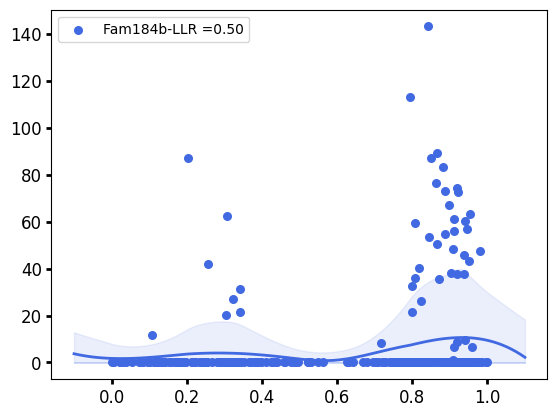

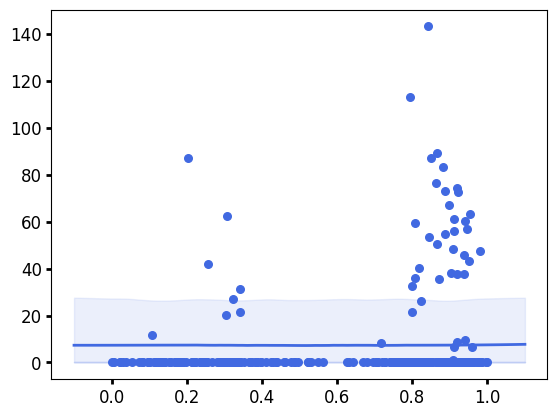

<Figure size 640x480 with 0 Axes>

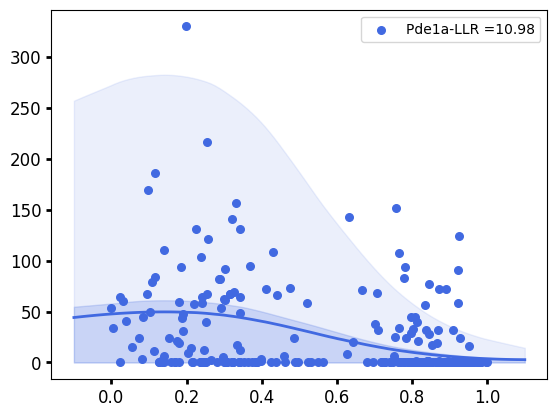

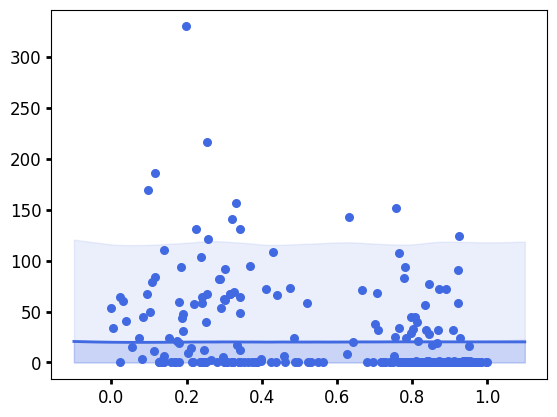

In [8]:
test_name = 'One_sample_test' # name of the test
results = gp_counts.One_sample_test(likelihood)
print('The results for '+likelihood+' likelihood:')
display(results)
params = gp_counts.load_predict_models(genes_name,test_name,likelihood)
plot(params,X.values,Y.loc[genes_name],results,test_name)

## 2. Fit GPcounts with negative binomial likelihood assuming sparse inference to obtain computational efficiency  on Fam184b and Pde1a genes

GPcounts by defaults use $5\%(N^*)$ to set the number of inducing points $M$ and [ $\epsilon- approximate\quad M-DPP$ algorithm](https://github.com/markvdw/RobustGP) to set the location of inducing points $Z$

$^* N = length(X)$

100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.18s/it]

The results for Negative_binomial likelihood:


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
Fam184b,-386.501826,-387.005186,0.503360
Pde1a,-818.595651,-829.576446,10.980795


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.25it/s]

Fam184b


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.82535
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.1419430767118119
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,32.99023
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(16, 1)",float64,[[0.71943149...
SVGP.q_mu,Parameter,Identity,,True,"(16, 1)",float64,[[3.95396781e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 16, 16)",float64,"[[[5.52676989e-01, 0.00000000e+00, 0.00000000e+00..."


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,3.75895
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,35.3769
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(16, 1)",float64,[[0.71943149...
SVGP.q_mu,Parameter,Identity,,True,"(16, 1)",float64,[[9.86665202e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 16, 16)",float64,"[[[-1.63102550e-01, 0.00000000e+00, 0.00000000e+00..."


Pde1a


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,8.09157
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.7633830213932769
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,9.483
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(16, 1)",float64,[[0.71943149...
SVGP.q_mu,Parameter,Identity,,True,"(16, 1)",float64,[[9.33735040e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 16, 16)",float64,"[[[8.26427685e-02, 0.00000000e+00, 0.00000000e+00..."


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,8.78014
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,10.92948
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(16, 1)",float64,[[0.71943149...
SVGP.q_mu,Parameter,Identity,,True,"(16, 1)",float64,[[9.98220910e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 16, 16)",float64,"[[[-6.12982978e-02, 0.00000000e+00, 0.00000000e+00..."


<Figure size 640x480 with 0 Axes>

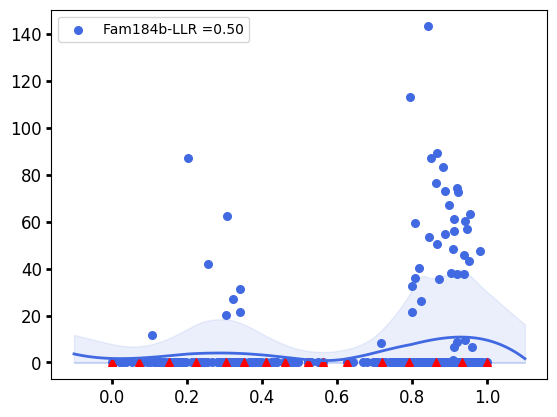

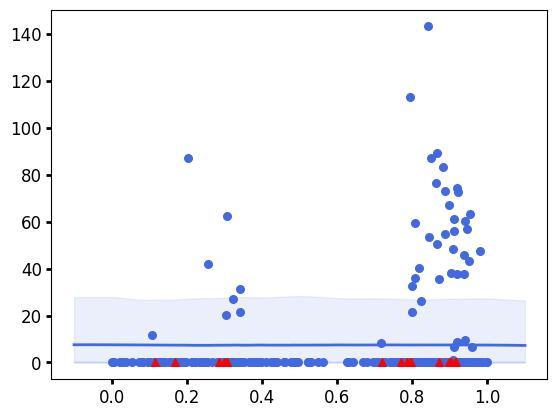

<Figure size 640x480 with 0 Axes>

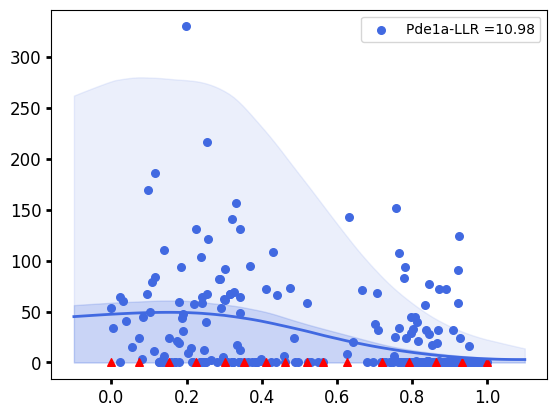

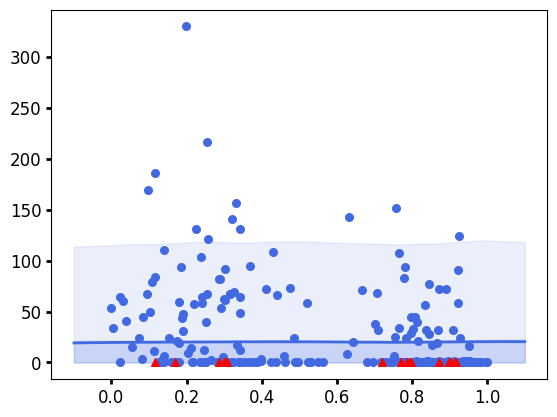

In [9]:
sparse = True 
gp_counts = rna_seq_gp(X,Y.loc[genes_name],sparse = sparse,safe_mode = True) # use sparse inference

results = gp_counts.One_sample_test(likelihood)
print('The results for '+likelihood+' likelihood:')
display(results)
params = gp_counts.load_predict_models(genes_name,test_name,likelihood)
plot(params,X.values,Y.loc[genes_name],results,test_name = test_name,sparse = sparse)

To set the number of inducing points $M = 4$ and use 𝜖−𝑎𝑝𝑝𝑟𝑜𝑥𝑖𝑚𝑎𝑡𝑒𝑀−𝐷𝑃𝑃 algorithm to set the location of inducing points  𝑍

100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.81s/it]

The results for Negative_binomial likelihood:


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
Fam184b,-386.527592,-387.005186,0.477595
Pde1a,-818.597244,-829.576449,10.979205


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.18it/s]

Fam184b


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,3.37664
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.14189
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,34.49434
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(4, 1)",float64,[[0.71943149...
SVGP.q_mu,Parameter,Identity,,True,"(4, 1)",float64,[[1.05442...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 4, 4)",float64,"[[[-0.17886749, 0., 0...."


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,3.76077
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,35.37798
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(4, 1)",float64,[[0.71943149...
SVGP.q_mu,Parameter,Identity,,True,"(4, 1)",float64,[[9.86452433e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 4, 4)",float64,"[[[-1.63083039e-01, 0.00000000e+00, 0.00000000e+00..."


Pde1a


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,8.1046
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.7660801534154589
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,9.48159
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(4, 1)",float64,[[0.71943149...
SVGP.q_mu,Parameter,Identity,,True,"(4, 1)",float64,[[0.93257412...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 4, 4)",float64,"[[[0.08242854, 0., 0...."


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,8.781
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,10.92944
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(4, 1)",float64,[[0.71943149...
SVGP.q_mu,Parameter,Identity,,True,"(4, 1)",float64,[[9.98167163e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 4, 4)",float64,"[[[-6.13000204e-02, 0.00000000e+00, 0.00000000e+00..."


<Figure size 640x480 with 0 Axes>

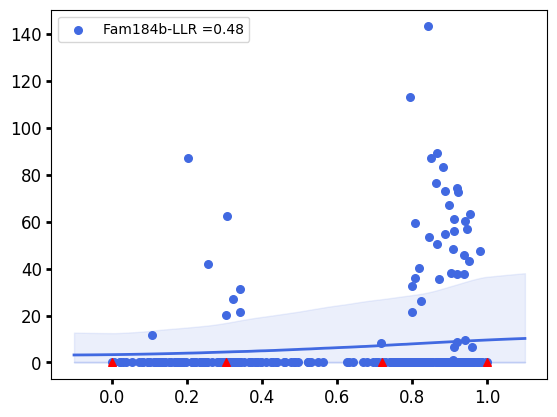

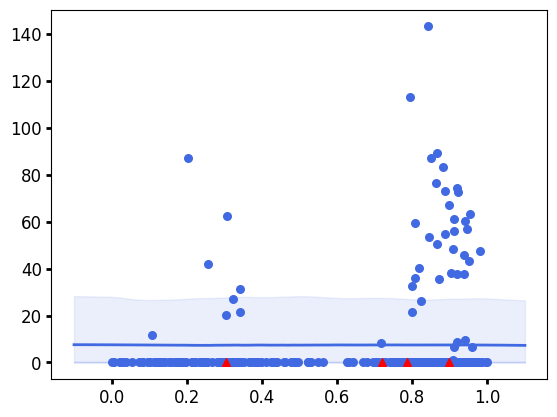

<Figure size 640x480 with 0 Axes>

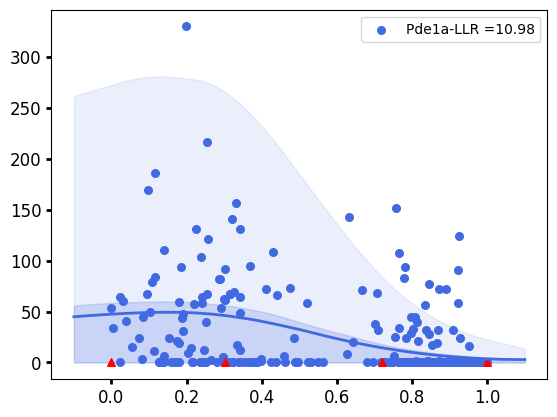

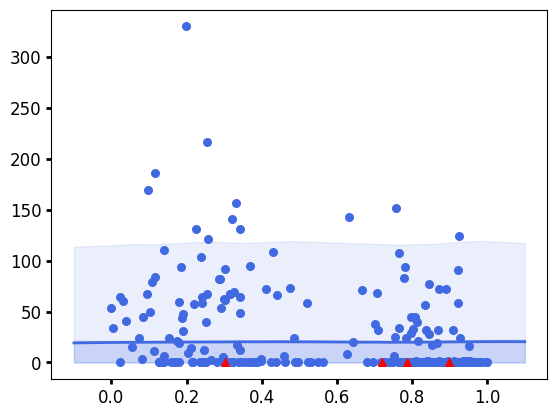

In [10]:
gp_counts = rna_seq_gp(X,Y.loc[genes_name],M = 4, sparse = sparse,safe_mode = True) # use sparse inference

results = gp_counts.One_sample_test(likelihood)
print('The results for '+likelihood+' likelihood:')
display(results)
params = gp_counts.load_predict_models(genes_name,test_name,likelihood)
plot(params,X.values,Y.loc[genes_name],results,test_name,sparse)

To use k-mean algorithm to set the location of inducing points 𝑍

$^*$ GPcounts by defaults use $5\%(N^*)$ to set the number of inducing points $M$ if M not specified

100%|█████████████████████████████████████████████| 2/2 [00:05<00:00,  2.52s/it]

The results for Negative_binomial likelihood:


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
Fam184b,-386.527580,-387.005186,0.477607
Pde1a,-818.825736,-829.576446,10.750710


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.31it/s]

Fam184b


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,3.36728
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.14302
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,34.48013
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(16, 1)",float64,[[-1.46681...
SVGP.q_mu,Parameter,Identity,,True,"(16, 1)",float64,[[-1.07897433e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 16, 16)",float64,"[[[9.27491884e-01, 0.00000000e+00, 0.00000000e+00..."


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,3.75895
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,35.3769
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(16, 1)",float64,[[0.03083525...
SVGP.q_mu,Parameter,Identity,,True,"(16, 1)",float64,[[9.86665202e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 16, 16)",float64,"[[[-1.63102550e-01, 0.00000000e+00, 0.00000000e+00..."


Pde1a


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,4.36771
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.6754428589657591
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,9.48079
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(16, 1)",float64,[[-0.17615782...
SVGP.q_mu,Parameter,Identity,,True,"(16, 1)",float64,[[1.49851000e+00...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 16, 16)",float64,"[[[3.90513750e-01, 0.00000000e+00, 0.00000000e+00..."


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,8.78014
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,10.92948
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(16, 1)",float64,[[0.03083525...
SVGP.q_mu,Parameter,Identity,,True,"(16, 1)",float64,[[9.98220910e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 16, 16)",float64,"[[[-6.12982978e-02, 0.00000000e+00, 0.00000000e+00..."


<Figure size 640x480 with 0 Axes>

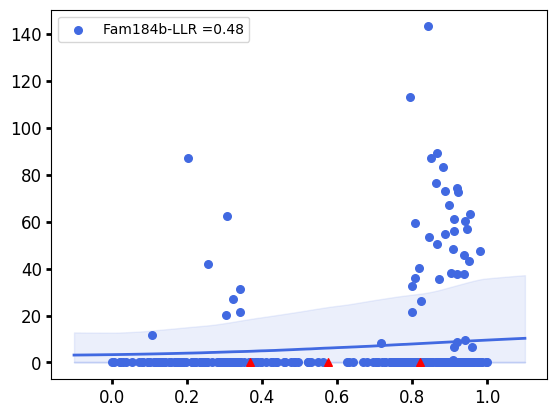

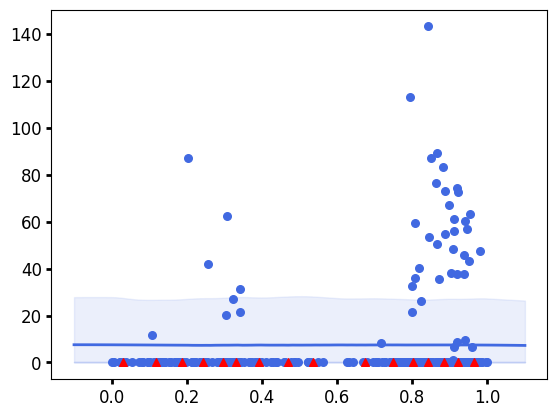

<Figure size 640x480 with 0 Axes>

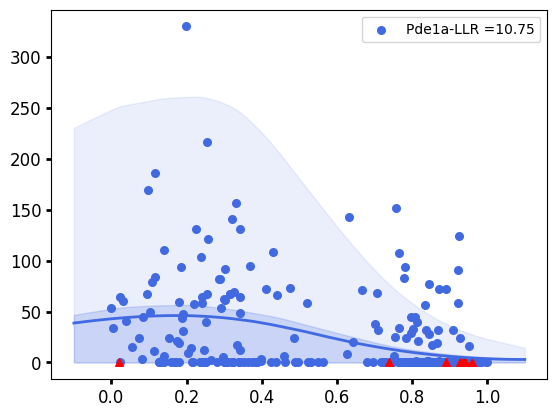

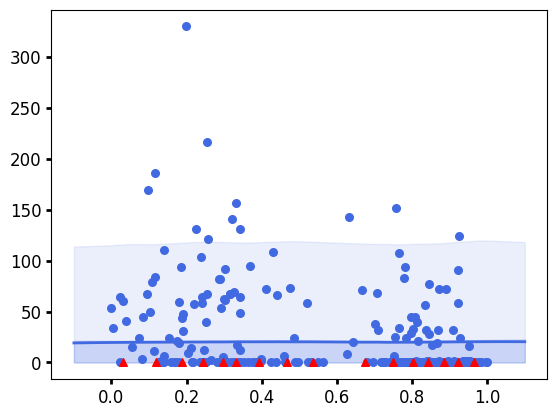

In [11]:
gp_counts = rna_seq_gp(X,Y.loc[genes_name],sparse = sparse,safe_mode = True) # use sparse inference
gp_counts.M = 16
gp_counts.kmeans = True

results = gp_counts.One_sample_test(likelihood)
print('The results for '+likelihood+' likelihood:')
display(results)
params = gp_counts.load_predict_models(genes_name,test_name,likelihood)
plot(params,X.values,Y.loc[genes_name],results,test_name,sparse)